### Importing Libraries

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import pathlib
import tensorflow_hub as hub

print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.20.0


### Define Dataset Paths and Class Names

In [8]:
train_dir = 'chest_xray/train'  # Path to training dataset
val_dir = 'chest_xray/val'      # Path to validation dataset
test_dir = 'chest_xray/test'    # Path to test dataset

# Detect class names from the training directory
data_dir = pathlib.Path(train_dir)
class_names = np.array(sorted([item.name for item in data_dir.glob('*') if item.is_dir()]))
print("Classes detected:", class_names)

for c in class_names:
    count = len(list(pathlib.Path(train_dir).glob(f'{c}/*.jpeg')))
    print(f'{c}: {count} images')

Classes detected: ['NORMAL' 'PNEUMONIA']
NORMAL: 1341 images
PNEUMONIA: 3875 images


### Data Loaders with Augmentation for Train, Rescaling for Val Test

In [9]:
batch_size = 32
img_height, img_width = 224, 224

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True)

val_test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    color_mode='rgb',
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True)

val_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=(img_height, img_width),
    color_mode='rgb',
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False)

test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    color_mode='rgb',
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False)

Found 5216 images belonging to 2 classes.
Found 47 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [11]:
# Build EfficientNetV2 model with transfer learning
from tensorflow.keras.applications import EfficientNetV2B0
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

## Load pre-trained EfficientNetV2B0 model without top layers
base_model = EfficientNetV2B0(
    weights='imagenet',
    include_top=False,
    input_shape=(img_height, img_width, 3)
)

# Unfreeze the last few layers for fine-tuning to increase trainable parameters
base_model.trainable = True

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

# Add custom classification head with more parameters
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.2)(x)

# Get number of classes from train generator
num_classes = train_generator.num_classes
predictions = Dense(num_classes, activation='softmax')(x)

# Create the model
model_efficientnetv2 = Model(inputs=base_model.input, outputs=predictions)

# Compile the model with lower learning rate for fine-tuning
model_efficientnetv2.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Display model summary
model_efficientnetv2.summary()


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_2         │ (None, 224, 224,  │          0 │ input_layer_2[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization_2     │ (None, 224, 224,  │          0 │ rescaling_2[0][0] │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ normalization_2[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │      4,608 │ stem_activation[… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_bn  │ (None, 112, 112,  │         64 │ block1a_project_… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_ac… │ (None, 112, 112,  │          0 │ block1a_project_… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_conv │ (None, 56, 56,    │      9,216 │ block1a_project_… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_bn   │ (None, 56, 56,    │        256 │ block2a_expand_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_act… │ (None, 56, 56,    │          0 │ block2a_expand_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_project_co… │ (None, 56, 56,    │      2,048 │ block2a_expand_a… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_project_bn  │ (None, 56, 56,    │        128 │ block2a_project_… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2b_expand_conv │ (None, 56, 56,    │     36,864 │ block2a_project_… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2b_expand_bn   │ (None, 56, 56,    │        512 │ block2b_expand_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2b_expand_act… │ (None, 56, 56,    │          0 │ block2b_expand_b

 Total params: 6,707,026 (25.59 MB)

 Trainable params: 5,943,362 (22.67 MB)

 Non-trainable params: 763,664 (2.91 MB)

In [15]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Define callbacks
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    min_lr=1e-7)

# Unfreeze all layers or a subset for fine-tuning
base_model.trainable = True

model_efficientnetv2.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy'])

# Continue training
history_finetune = model_efficientnetv2.fit(
    train_generator, validation_data=val_generator,
    epochs=10, callbacks=[early_stop, reduce_lr])


Epoch 1/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 443s 2s/step - accuracy: 0.7776 - loss: 0.4736 - val_accuracy: 0.7660 - val_loss: 0.5025 - learning_rate: 1.0000e-04
Epoch 2/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 560s 3s/step - accuracy: 0.7926 - loss: 0.4461 - val_accuracy: 0.5106 - val_loss: 0.8406 - learning_rate: 1.0000e-04
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 521s 3s/step - accuracy: 0.8031 - loss: 0.4230 - val_accuracy: 0.5319 - val_loss: 1.9906 - learning_rate: 1.0000e-04
Epoch 4/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 553s 3s/step - accuracy: 0.8160 - loss: 0.4112 - val_accuracy: 0.4894 - val_loss: 2.3169 - learning_rate: 1.0000e-04
Epoch 5/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 521s 3s/step - accuracy: 0.8244 - loss: 0.3884 - val_accuracy: 0.5106 - val_loss: 1.1336 - learning_rate: 2.0000e-05
Epoch 6/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 522s 3s/step - accuracy: 0.8345 - loss: 0.3706 - val_accuracy: 0.7872 - val_loss: 0.4949 - learning_rate: 2.0000e-05
Epoch 7/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 526s 3s/step - acc

In [13]:
   
   # Evaluate fine-tuned model on validation set
val_loss, val_acc = model_efficientnetv2.evaluate(val_generator)
print(f'Fine-tuned ResNet50 Validation Accuracy: {val_acc:.4f}, Loss: {val_loss:.4f}')

   

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 389ms/step - accuracy: 0.7447 - loss: 0.5660
Fine-tuned ResNet50 Validation Accuracy: 0.7447, Loss: 0.5660


In [14]:
# Evaluate fine-tuned model on test set for unbiased performance
test_loss, test_acc = model_efficientnetv2.evaluate(test_generator)
print(f'Fine-tuned ResNet50 Test Accuracy: {test_acc:.4f}, Loss: {test_loss:.4f}')


20/20 ━━━━━━━━━━━━━━━━━━━━ 16s 779ms/step - accuracy: 0.7692 - loss: 0.5662
Fine-tuned ResNet50 Test Accuracy: 0.7692, Loss: 0.5662


In [16]:
# Save your fine-tuned model for future use or deployment
model_efficientnetv2.save('efficientnetv2_chest_xray_finetuned.h5')
print("Model saved as 'efficientnetv2_chest_xray_finetuned.h5'")

Model saved as 'efficientnetv2_chest_xray_finetuned.h5'


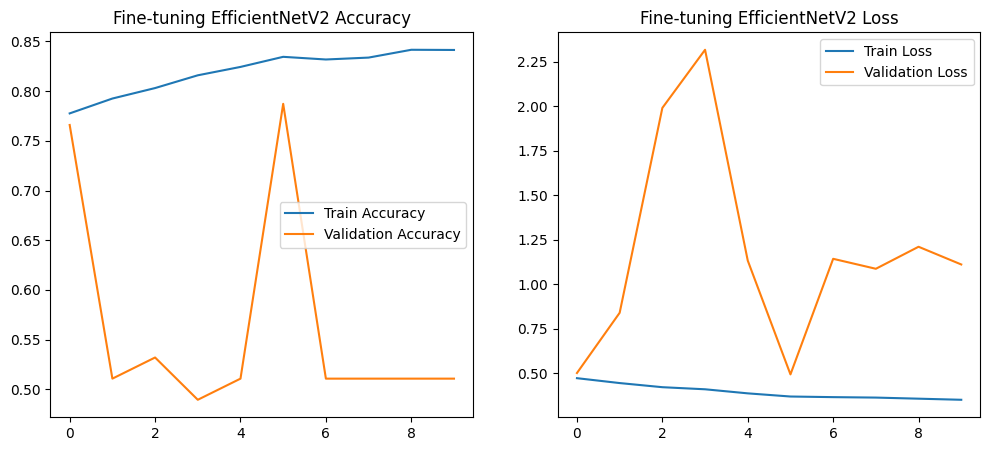

In [17]:
# Plot training and validation accuracy/loss curves for fine-tuning phase
import matplotlib.pyplot as plt

def plot_training(history, title):
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(title + ' Accuracy')
    plt.legend()
    
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(title + ' Loss')
    plt.legend()
    
    plt.show()

plot_training(history_finetune, 'Fine-tuning EfficientNetV2')


20/20 ━━━━━━━━━━━━━━━━━━━━ 19s 921ms/step


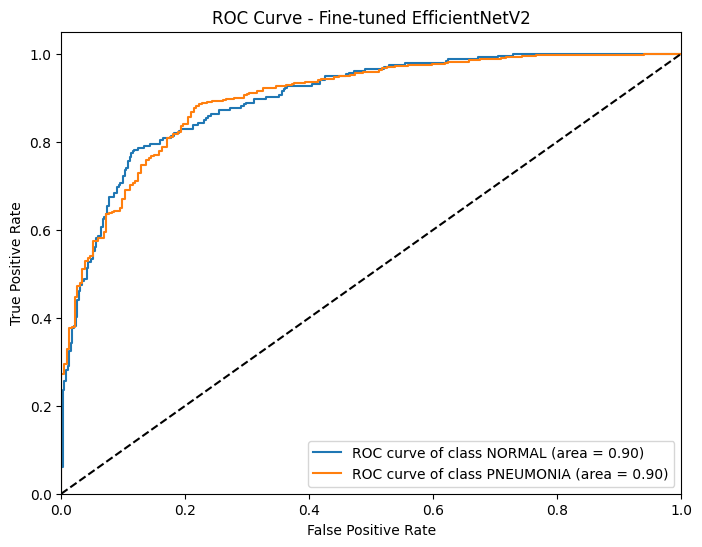

In [19]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import numpy as np

# Get predictions and probabilities from the Keras model
test_predictions = model_efficientnetv2.predict(test_generator)
test_pred_classes = np.argmax(test_predictions, axis=1)

# Get true labels
test_true_classes = test_generator.classes

# Use the predictions as probabilities (they are already softmax outputs)
all_probs = test_predictions
all_labels = test_true_classes

n_classes = len(class_names)
fpr = dict()
tpr = dict()
roc_auc = dict()

# Calculate ROC curve for each class
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(all_labels == i, all_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves
plt.figure(figsize=(8, 6))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'ROC curve of class {class_names[i]} (area = {roc_auc[i]:0.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Fine-tuned EfficientNetV2')
plt.legend(loc='lower right')
plt.show()

Classification Report:
              precision    recall  f1-score   support

      Normal     0.6074    0.9060    0.7273       234
   Pneumonia     0.9200    0.6487    0.7609       390

    accuracy                         0.7452       624
   macro avg     0.7637    0.7774    0.7441       624
weighted avg     0.8028    0.7452    0.7483       624



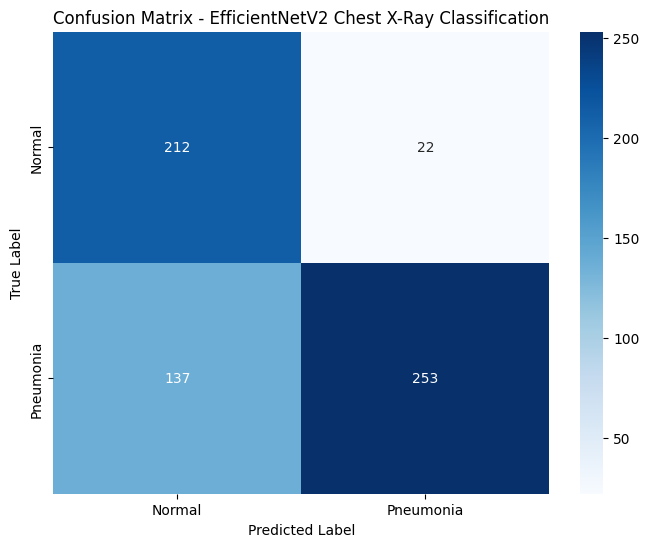


Detailed Metrics:
Accuracy: 0.7452
Precision: 0.9200
Recall (Sensitivity): 0.6487
Specificity: 0.9060
F1-Score: 0.7609


In [20]:
# Generate Classification Report
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Get binary predictions (0 or 1)
test_predictions_binary = (test_predictions_prob > 0.5).astype(int)

# Generate classification report
class_names = ['Normal', 'Pneumonia']
report = classification_report(test_labels, test_predictions_binary, 
                             target_names=class_names, 
                             digits=4)

print("Classification Report:")
print("=" * 50)
print(report)

# Generate and plot confusion matrix
cm = confusion_matrix(test_labels, test_predictions_binary)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix - EfficientNetV2 Chest X-Ray Classification')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Calculate additional metrics
tn, fp, fn, tp = cm.ravel()
accuracy = (tp + tn) / (tp + tn + fp + fn)
precision = tp / (tp + fp)
recall = tp / (tp + fn)
specificity = tn / (tn + fp)
f1_score = 2 * (precision * recall) / (precision + recall)

print(f"\nDetailed Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall (Sensitivity): {recall:.4f}")
print(f"Specificity: {specificity:.4f}")
print(f"F1-Score: {f1_score:.4f}")
